In [ ]:
from cvxpy_portfolio_optimizer.objective_function import TrackingErrorObjectiveFunction
from cvxpy_portfolio_optimizer.constraint_function import SumToOneConstraint, NoShortSellConstraint
from cvxpy_portfolio_optimizer.portfolio_optimization_problem import PortfolioOptimizationProblem
import yfinance as yf

In [2]:
tickers = ["TSLA", "MSFT", "IBM", "GOOG", "AAPL", "AMZN", "ADBE", "EXC", "XOM", "META"]
rets = (
    yf.download(tickers, period="1y")["Adj Close"].loc[:, tickers].pct_change().iloc[1:, :].ffill()
)
rets

[*********************100%***********************]  10 of 10 completed


,TSLA,MSFT,IBM,GOOG,AAPL,AMZN,ADBE,EXC,XOM,META
Date,,,,,,,,,,
2022-05-24,-0.069255,-0.003952,0.020051,-0.051407,-0.019216,-0.032141,-0.020528,0.019628,0.005432,-0.076186
2022-05-25,0.048777,0.011170,0.004410,-0.000817,0.001140,0.025696,0.010266,0.003891,0.020127,0.014067
2022-05-26,0.074271,0.012875,0.018603,0.023210,0.023200,0.040295,0.015155,0.002856,0.003531,0.042431
2022-05-27,0.073333,0.027604,0.017386,0.041581,0.040757,0.036632,0.048018,0.014036,0.009830,0.018264
2022-05-31,-0.001804,-0.005014,-0.003088,0.010993,-0.005346,0.043970,-0.027416,-0.014042,-0.016293,-0.007636
...,...,...,...,...,...,...,...,...,...,...
2023-05-17,0.044079,0.009452,0.018225,0.011575,0.003603,0.018519,0.033381,-0.002794,0.022435,0.015367
2023-05-18,0.017428,0.014395,0.003500,0.016793,0.013666,0.022944,0.010655,0.003311,0.009063,0.017980
2023-05-19,0.018373,-0.000565,0.008799,-0.002186,0.000628,-0.016081,0.030020,0.012186,0.004633,-0.004902


In the following portfolio optimization problem we will:
- Minimize Tracking Error on a universe of 10 assets with respect to a benchmark, (bench_rets) in this case the SP500 etf

In [3]:
bench_rets = yf.download(["SPY"], period="1y")["Adj Close"].pct_change().iloc[1:].ffill()
bench_rets

[*********************100%***********************]  1 of 1 completed


Date
2022-05-24   -0.007634
2022-05-25    0.008835
2022-05-26    0.019981
2022-05-27    0.024549
2022-05-31   -0.005611
                ...   
2023-05-17    0.012139
2023-05-18    0.009633
2023-05-19   -0.001455
2023-05-22    0.000406
2023-05-23   -0.002173
Name: Adj Close, Length: 251, dtype: float64

In [31]:
pop = PortfolioOptimizationProblem(
    returns=rets,
    objective_functions=[
        TrackingErrorObjectiveFunction(benchmark_returns=bench_rets),
    ],
    constraint_functions=[
        SumToOneConstraint(),
        NoShortSellConstraint(),
    ],
)
ptf = pop.solve(solver="ECOS")

In [32]:
ptf.weights

TSLA    0.047963
MSFT    0.102629
IBM     0.216223
GOOG    0.050939
AAPL    0.115403
AMZN    0.072155
ADBE    0.033760
EXC     0.181296
XOM     0.139083
META    0.040549
dtype: float64

<Axes: xlabel='Date'>

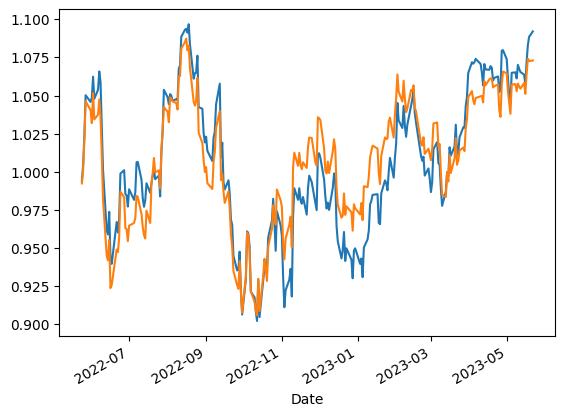

In [33]:
ptf_rets = rets.dot(ptf.weights)
(1 + ptf_rets).cumprod().plot()
(1 + bench_rets).cumprod().plot()

In [34]:
# Tracking error
(ptf_rets - bench_rets).std()

0.004196494581223359